In [1]:
# In this baseline python notebook, we loaded the dataset from Kaggle and attempted training with
# a simple NN with no hidden layers, 2 and 3 and 4 -convolutional-layers with fully connected layer.
# Also did some work to improve the facial keypoint identification such as blurring the image and 
# movement, and reran through NN to see if accuracy improved

# Reference-https://www.tensorflow.org/get_started/mnist/pros

# Loading required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import matplotlib.pyplot as plt
import scipy.signal



# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

np.random.seed(0)


In [2]:
# Some additional work to improve accuracy: blur images, move images
#flips images horizontally
def flip_images(inputdata):
    data=inputdata.copy()
    origcols = list(data.columns)
    newcols = [item for item in origcols]
    
    for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: -x)
    #print data.head()
    
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
    
    for (a,b) in flip_indices:
        newcols[a],newcols[b] = newcols[b],newcols[a]

    colmap = {}
    for i in range(len(newcols)):
        colmap[origcols[i]]=newcols[i]
    
    data = data[newcols]
    data.rename(columns = colmap,inplace=True)
    #print data.head()

    
    data["Image"] = data["Image"].apply(lambda x: np.fliplr(x.reshape((96,96))).flatten())

    return data


def blur_images(inputdata):
    data=inputdata.copy()
    data["Image"] = data["Image"].apply(lambda x: (scipy.signal.convolve2d(x.reshape((96,96)),np.ones((3,3)), mode='same',boundary="fill")/9.0).ravel() )
    return data

In [3]:
# Create iterator to deliver data & labels in sets of batchSize
def imgs_iterator(data,labels,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
            batchIndices = indices[i:i+batchSize]
            yield np.stack(data[batchIndices]),labels[batchIndices],len(batchIndices)

# Same as imgs_iterator but for test data (don't return labels)
def imgs_iterator_predict(data,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
        batchIndices = indices[i:i+batchSize]
        
        yield np.stack(data[batchIndices]),len(batchIndices)

# Make predictions according to formula "y = Wx + b" for data set 
# Similar in form to training loop
def make_predictions(data,batch_size):
    results = data.copy()
    predictions_mb=[]
    # Iterate by batch size
    iter_test = imgs_iterator_predict(data,batch_size)
    try:
        next_batch =iter_test.__next__()
        while next_batch!=None:
            
            # Load next batch
            mini_batch,batch_size = next_batch
            
            # Reshape
            mini_batch = np.reshape(mini_batch,(batch_size,9216))
            
            # Make prediction with input data and dropout 
            feed_dict = {x: np.stack(mini_batch), keep_prob: 1.0}
            predictions = y.eval(feed_dict)
            predictions_mb.append(predictions)
            
            next_batch =iter_test.__next__()
    except StopIteration:
        next_batch=None
    results = pd.DataFrame(np.vstack(predictions_mb))
    
    return results

# Generate reports for submission
def generate_results(result):
    submission = pd.read_csv('/home/ubuntu/FacialKeypoints/data/SampleSubmission.csv')
    IdLookup = pd.read_csv('/home/ubuntu/FacialKeypoints/data/IdLookupTable.csv')
    IdLookupDict = IdLookup.set_index('RowId').T.to_dict('list')

    
    
    result.columns = dev.columns[0:30]
    output = pd.concat([test["ImageId"],result_test],axis=1)
    
    RowId = np.asarray(submission["RowId"],dtype=int)
    for row in RowId:
        r = IdLookupDict[row][0]-1
        c =IdLookupDict[row][1]
        submission.loc[row-1,"Location"]= min(96,(output.loc[r,c]))
    
    
    submission.to_csv("submission.csv",index=False)


In [4]:
# Loading the test and raw training datasets
# Raw is 7049X31.  7049 training examples, 30 columns of facial feature x &y locations, 1 column for list of image pixel values
# Test is 1783X2. 1783 test examples, 1 column for image id, 1 column for list of image pixel values
raw = pd.read_csv('/home/ubuntu/FacialKeypoints/data/training.csv')
test = pd.read_csv('/home/ubuntu/FacialKeypoints/data/test.csv')


# Converting image data into numpy arrays and scaling the images
raw["Image"] = raw["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)
test["Image"] = test["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)

for col in raw.columns.get_level_values(0)[0:30]:
    raw[col] = raw[col].apply(lambda x: (x-48)/48)
    
    




In [5]:
# Dropping training & test cases with na values since they will prevent the model from training correctly.
# Possibly revisit this to come up with a better approach
raw.dropna(inplace=True)
test.dropna(inplace=True)


# After removing the cases with 'na', re-shuffle (the training set) and re-do indexing
raw = raw.sample(frac=1)
raw.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


In [6]:
raw = pd.concat([raw,flip_images(raw)],axis=0)
raw = raw.sample(frac=1)
#,move_images(train,15,"right"),move_images(train,15,"left")
                  #,move_images(train,15,"up"),move_images(train,15,"down")

raw.reset_index(inplace=True,drop=True)

In [7]:
# Our training data set has 2140 examples at this point.  
# Allocate 1800 for training and 340 for development.
train_size = int(raw.shape[0]*.8)
train = raw.iloc[0:train_size,:]
dev = raw.iloc[train_size:raw.shape[0],:]

# Re-index
train.reset_index(inplace=True,drop=True)
dev.reset_index(inplace=True,drop=True)

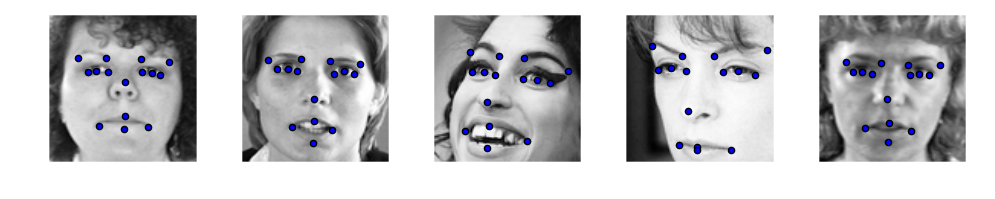

In [8]:
# Visualize 5 example images:
def plot_images(num_images,inputdata, inputresult=None,training=True):
    data=inputdata.copy()
    if inputresult is not None:
        result = inputresult.copy()
    plt.figure(figsize=(12,4))
    
    for col in data.columns.get_level_values(0)[0:30]:
            data[col] = data[col].apply(lambda x: x*48+48)
    
    if training==False:
        for col in result.columns.get_level_values(0)[0:30]:
            result[col] = result[col].apply(lambda x: x*48+48)
    
    
    for i in range(num_images):
        
        # Every example has 30 facial features and 1 column with a 9216-length list of pixel values of image
        # take the 9216 list of pixels and reshape into 96X96 image for viewing
        img =  np.reshape(data.ix[i:i,"Image"].values[0],(96,96))
        plt.subplot(1,num_images,i+1)
        plt.axis('off')
        
        # Show the facial image
        plt.imshow(img,cmap='Greys_r')
        
        
    

        # Get x & y values for the facial keypoints and overlay on the face
        x_values = np.asarray(data[data.columns.get_level_values(0)[0:30:2]])
        y_values = np.asarray(data[data.columns.get_level_values(0)[1:30:2]])
        plt.scatter(x_values[i],y_values[i])
        
        # If we are not using training data, then show our predicted facial keypoints with red x's
        if training==False:
            
        
            
            rx_values = np.asarray(result[result.columns.get_level_values(0)[0:30:2]])
            ry_values = np.asarray(result[result.columns.get_level_values(0)[1:30:2]])
            plt.scatter(rx_values[i],ry_values[i],marker="x",color='r')
            

plot_images(5,train)

In [9]:

# Convert the pixel arrays and facial feature locations in train/dev/test into numpy-array representation
train_data = train["Image"].as_matrix()
train_labels = np.asarray(train[train.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

dev_data = dev["Image"].as_matrix()
dev_labels = np.asarray(dev[dev.columns.get_level_values(0)[0:30]]).astype(dtype = np.float32)

test_data = test["Image"].as_matrix()

In [11]:
# Try 2-convolutional-layers, 1 fully connected

mini_batch_size=400
epochs = 300

# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')



# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])


# Weights will be 4D tensor of size 5x5x1x32 from truncated normal, 32-length array bias of constant 0.1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])


# x_image is in shape [batch, in_height, in_width, in_channels] ~ [-1, 96, 96, 1]
# W_conv1 is in shape [filter_height, filter_width, in_channels, out_channels] ~ [5,5,1,32]
# conv2d flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels]
#      ~ [5*5*1, 32] ~ [25, 32]
# Apply rectifier relu function
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# Perform reduction.  h_conv1 is [?,96,96,32] with strides [1,2,2,1]
# Returns a 48*48 image with 32 filters
h_pool1 = max_pool_2x2(h_conv1)

# 2nd convolutional layer - will return 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# Flatten resulting image to apply relu activation
h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*64])

# Fully connected layer
W_fc1 = weight_variable([24 * 24 * 64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Apply dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Determine prediction function "y=Wx+b"
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define loss function, try minimize with AdamOptimizer (more efficient than gradient descent)
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-3).minimize(error)


with tf.Session() as sess:
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate over training data in increments of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape 
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Determine accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+" ="+str(train_accuracy))
        
    
        # Measure accuracy with trained NN on dev data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)

        # Get batch of 20 from dev data
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch

        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))

        # Calculate accuracy
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
    
    

    # Generate predictions for display
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    sess.close()


KeyboardInterrupt: 

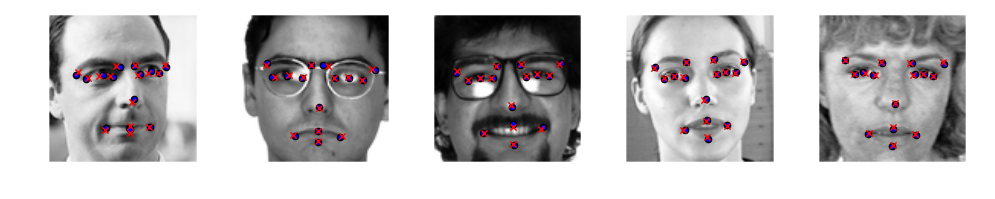

In [78]:
# Plot our predictions
plot_images(5,inputdata =dev,inputresult=result_dev,training=False)

In [68]:
# Try 3 convolutional layers, 1 fully connected

mini_batch_size=400
epochs = 10

# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')


# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Our third convolutional layer, returns a 12*12 image with 128 filters
W_conv3 = weight_variable([5, 5, 64, 128])
b_conv3 = bias_variable([128])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)


# Flatten resulting image to apply relu activation
h_pool3_flat = tf.reshape(h_pool3, [-1, 12*12*128])

# Fully connected layer
W_fc1 = weight_variable([12 * 12 * 128, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

# Dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


# Apply error function with prediction function "y= xW+b" as previously
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define loss function, try minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-4).minimize(error)

epoch=[i for i in range(epochs)]

# Collect magnitudes of the training and dev errors over epochs for visualization
train_error = []
dev_error = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        # Iterate over training data in increments of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.25})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
        # Test accuracy on the unseen (dev) data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20 from dev
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    
    # Generate predictions for display
    result_dev =make_predictions(dev_data, mini_batch_size-1)

    sess.close()

RMSE for Epoch 0 =1.70835
RMSE for dev set =1.50573
RMSE for Epoch 1 =0.403499
RMSE for dev set =0.401965
RMSE for Epoch 2 =0.40261
RMSE for dev set =0.40311
RMSE for Epoch 3 =0.394823
RMSE for dev set =0.398654
RMSE for Epoch 4 =0.397447
RMSE for dev set =0.397883
RMSE for Epoch 5 =0.393916
RMSE for dev set =0.396951
RMSE for Epoch 6 =0.399035
RMSE for dev set =0.393156
RMSE for Epoch 7 =0.398881
RMSE for dev set =0.388793
RMSE for Epoch 8 =0.392779
RMSE for dev set =0.386916
RMSE for Epoch 9 =0.386039
RMSE for dev set =0.38837


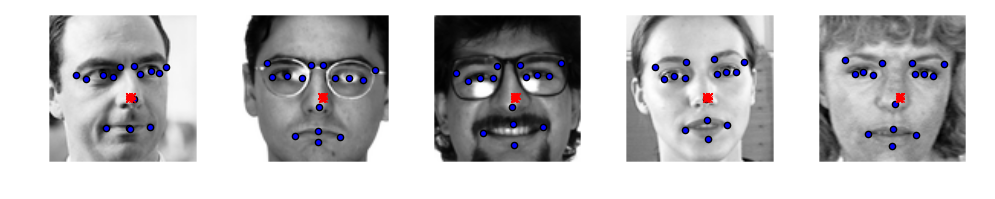

In [69]:
# Plot predictions from dev data
plot_images(5,inputdata =dev,inputresult=result_dev,training=False)

In [74]:
# Try 4 convolutional layers, 1 fully connected

mini_batch_size=400
epochs = 100

# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])

# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])#-1 because we don't know the batch size yet.

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([3, 3, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Same as previous exercise, next return a 12*12 image with 128 filters
W_conv3 = weight_variable([3, 3, 64, 128])
b_conv3 = bias_variable([128])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Fourth convolutional layer, returns a 6*6 image with 256 filters
W_conv4 = weight_variable([3, 3, 128, 256])
b_conv4 = bias_variable([256])
h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
h_pool4 = max_pool_2x2(h_conv4) #returns a 6*6 image with 256 filters

# Flatten resulting image for matrix multiplication
h_pool4_flat = tf.reshape(h_pool4, [-1, 6*6*256])
# Fully connected layer
W_fc1 = weight_variable([6 * 6 * 256, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)

# Dropout to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Prediction y=xW+b
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Define RMSE loss function, minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-3).minimize(error)


epoch=[i for i in range(epochs)]

# Collect train and dev error magnitudes for visualization
train_error = []
dev_error = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate over training data in steps of (mini_batch_size-1)
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate accuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of 20 training examples
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
        # Test accuracy on the unseen (dev) data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20 from dev
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    # Generate predictions for train/dev/test
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    
    sess.close()

RMSE for Epoch 0 =0.223059
RMSE for dev set =0.210596
RMSE for Epoch 1 =0.128595
RMSE for dev set =0.124778
RMSE for Epoch 2 =0.0902792
RMSE for dev set =0.101126
RMSE for Epoch 3 =0.0913284
RMSE for dev set =0.0884679
RMSE for Epoch 4 =0.0861444
RMSE for dev set =0.0847818
RMSE for Epoch 5 =0.0808877
RMSE for dev set =0.0758741
RMSE for Epoch 6 =0.111572
RMSE for dev set =0.0773067
RMSE for Epoch 7 =0.0689789
RMSE for dev set =0.068368
RMSE for Epoch 8 =0.0850865
RMSE for dev set =0.0674656
RMSE for Epoch 9 =0.0742558
RMSE for dev set =0.0783535
RMSE for Epoch 10 =0.073405
RMSE for dev set =0.0771995
RMSE for Epoch 11 =0.0645684
RMSE for dev set =0.067259
RMSE for Epoch 12 =0.0692104
RMSE for dev set =0.0719164
RMSE for Epoch 13 =0.0635549
RMSE for dev set =0.0693215
RMSE for Epoch 14 =0.0686245
RMSE for dev set =0.0650108
RMSE for Epoch 15 =0.0687331
RMSE for dev set =0.0677746
RMSE for Epoch 16 =0.0636356
RMSE for dev set =0.0657413
RMSE for Epoch 17 =0.064974
RMSE for dev set =0.07

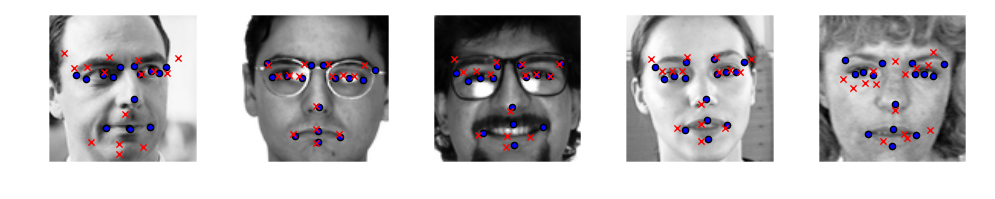

In [76]:
# Plot predictions from dev data
plot_images(5,inputdata =dev,inputresult=result_dev,training=False)

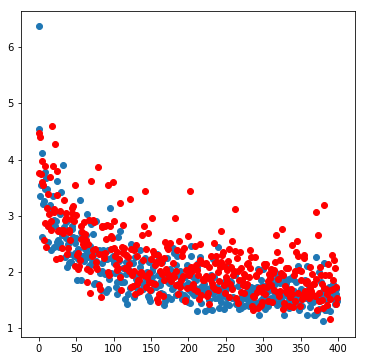

In [19]:

# Plot train/dev errors by epoch
plt.figure(figsize=(6,6))
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


In [71]:
# Try 2 convolutional layers, 2 fully connected layers

mini_batch_size=400
epochs = 100


# Set weights as 4D array of random values from truncated normal dist (most-common method)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Set constant bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Compute 2D convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pool on the input
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

# Will contain image pixels as we run the training loop
x = tf.placeholder(tf.float32, shape=[None, 9216])
# Will contain facial feature locations as we run training loop
y_ = tf.placeholder(tf.float32, shape=[None, 30])


# Reshape image to format [batch, in-height, in-width, in_channels] to run conv2d on it
# Batch is -1 since don't know batch size yet
x_image = tf.reshape(x, [-1,96,96,1])

# Same as previous exercize, return a 48*48 image with 32 filters
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


# Same as previous exercise, next return a 24*24 image with 64 filters
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) #returns a 24*24 image with 64 filters


# Fully connected layer
W_fc1 = weight_variable([24 * 24 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout to prevent overfit
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Fully connected layer
W_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# Prediction function
W_fc3 = weight_variable([1024, 30])
b_fc3 = bias_variable([30])
y = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

# Define RMSE error, minimize with AdamOptimizer
error = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_,y))))
train_step = tf.train.AdamOptimizer(1e-2).minimize(error)

epoch=[i for i in range(epochs)]

# Track train/dev errors for plotting
train_error = []
dev_error = []

# GPU settings
config = tf.ConfigProto()
config.gpu_options.allow_growth=True


with tf.Session(config=config) as sess:
    
    # Initialize global vars
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        
        # Iterate by batch size
        iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
        try:
            next_batch =iter_.__next__()
            while next_batch!=None:
                
                # Load next batch
                train_data_instance,train_label_instance,batch_size = next_batch
                
                # Reshape
                train_instance = np.reshape(train_data_instance,(batch_size,9216))
                train_label_instance = np.reshape(train_label_instance,(batch_size,30))
                
                # Calculate acccuracy
                train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                # Run training with next batch of training data
                sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                next_batch =iter_.__next__()
        except StopIteration:
            next_batch=None
        
        print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
        train_error.append(train_accuracy)
        
    
        # Determine accuracy on our dev data
        iter_dev = imgs_iterator(dev_data,dev_labels,batch_size)
        
        # Get batch of 20
        next_batch =iter_dev.__next__()
        dev_data_instance,dev_label_instance,batch_size = next_batch
        
        # Reshape
        dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
        dev_label_instance = np.reshape(dev_label_instance,(batch_size,30))
        
        # Calculate accuracy & error
        dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
        print ("RMSE for dev set ="+str(dev_accuracy))
        dev_error.append(dev_accuracy)
    
    

    #Predictions on train/dev/test for plotting
    #result =make_predictions(train_data, mini_batch_size-1)
    result_dev =make_predictions(dev_data, mini_batch_size-1)
    result_test =make_predictions(test_data, mini_batch_size-1)
    
    sess.close()

RMSE for Epoch 0 =0.155488
RMSE for dev set =0.174046
RMSE for Epoch 1 =0.0867024
RMSE for dev set =0.0769928
RMSE for Epoch 2 =0.071001
RMSE for dev set =0.0717444
RMSE for Epoch 3 =0.0695483
RMSE for dev set =0.0737979
RMSE for Epoch 4 =0.0667514
RMSE for dev set =0.0667918
RMSE for Epoch 5 =0.0630765
RMSE for dev set =0.0623076
RMSE for Epoch 6 =0.0681629
RMSE for dev set =0.0693671
RMSE for Epoch 7 =0.065469
RMSE for dev set =0.0671203
RMSE for Epoch 8 =0.0644159
RMSE for dev set =0.0651862
RMSE for Epoch 9 =0.0645634
RMSE for dev set =0.0656179
RMSE for Epoch 10 =0.07238
RMSE for dev set =0.0641339
RMSE for Epoch 11 =0.0680803
RMSE for dev set =0.0639218
RMSE for Epoch 12 =0.0602785
RMSE for dev set =0.0606263
RMSE for Epoch 13 =0.0701751
RMSE for dev set =0.0637056
RMSE for Epoch 14 =0.0703106
RMSE for dev set =0.0707344
RMSE for Epoch 15 =0.063505
RMSE for dev set =0.067191
RMSE for Epoch 16 =0.0687892
RMSE for dev set =0.0659048
RMSE for Epoch 17 =0.0648324
RMSE for dev set =0.

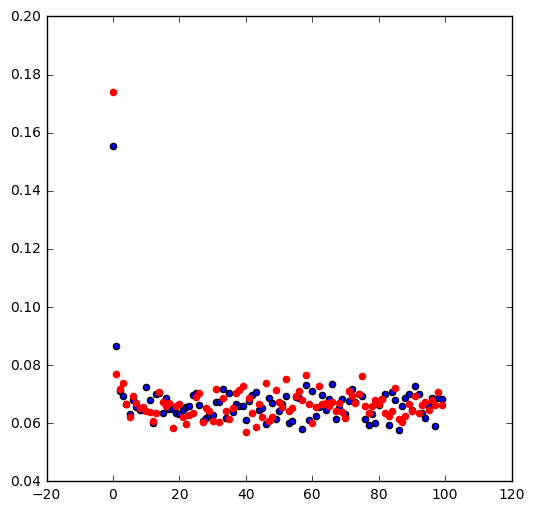

In [72]:
# Plot training and dev errors by epoch
plt.figure(figsize=(6,6))
plt.scatter(epoch,train_error)
plt.scatter(epoch,dev_error,color="red")


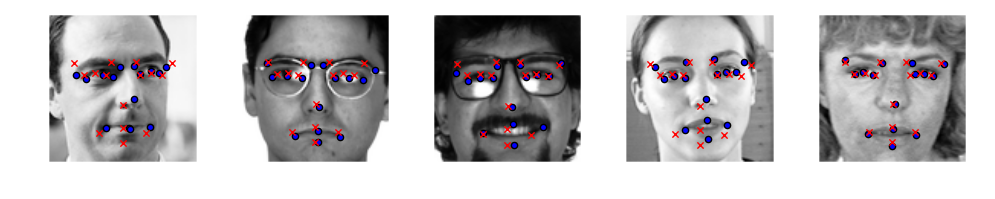

In [73]:
# Plot predicted facial keypoints from dev_data
plot_images(5,dev,result_dev,False) 

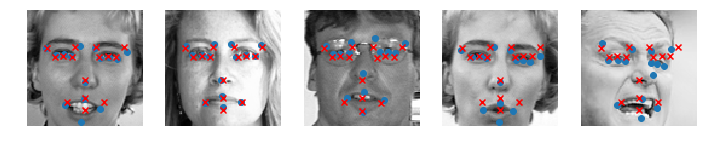

In [29]:
# Plot predicted facial keypoints from test_data
plot_images(5,train,result,False)

In [32]:
# Submission
generate_results(result_test)